In [1]:
pip install mesa

Note: you may need to restart the kernel to use updated packages.


# Ejemplo de Modelo SIR

**Creamos la clase agente y la clase modelo SIR**

In [70]:

from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import random
import matplotlib.pyplot as plt

# Definición del agente SIR
class SIRAgent(Agent):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2

    def __init__(self, unique_id, model, initial_state=SUSCEPTIBLE):
        super().__init__(unique_id, model)
        self.state = initial_state
        self.infection_time = 0
        self.individual_recovery_time = self.model.recovery_time + random.randint(-2, 2)
        
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def step(self):
        self.move()
        if self.state == self.INFECTED:
            self.infection_time += 1
            if self.infection_time >= self.individual_recovery_time:
                self.state = self.RECOVERED
            self.try_to_infect()

    def try_to_infect(self):
        if self.state == self.INFECTED:
            neighbors_nodes = self.model.grid.get_neighbors(self.pos, moore=True, include_center=False)
            susceptible_neighbors = [agent for agent in neighbors_nodes if agent.state == self.SUSCEPTIBLE]
            for neighbor in susceptible_neighbors:
                if random.random() < self.model.infection_rate:
                    neighbor.state = self.INFECTED

# Definición del modelo SIR
class SIRModel(Model):
    def __init__(self, N, width, height, infection_rate, recovery_time):
        super().__init__()
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.infection_rate = infection_rate
        self.recovery_time = recovery_time

        for i in range(self.num_agents):
            a = SIRAgent(i, self)
            self.schedule.add(a)
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            infected = random.random() < 0.05
            if infected:
                a.state = a.INFECTED

        self.datacollector = DataCollector(
            model_reporters={"Susceptible": lambda m: self.count_state(m, SIRAgent.SUSCEPTIBLE),
                             "Infected": lambda m: self.count_state(m, SIRAgent.INFECTED),
                             "Recovered": lambda m: self.count_state(m, SIRAgent.RECOVERED),
                             "R0": self.calculate_R0} 
        )
    
    def calculate_R0(self):
        susceptibles = self.count_state(self, SIRAgent.SUSCEPTIBLE)
        if susceptibles == 0:  # Evitar división por cero
            return 0
        return (self.infection_rate * susceptibles) / (1 / self.recovery_time)


    @staticmethod
    def count_state(model, state):
        return sum([1 for agent in model.schedule.agents if agent.state == state])

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()




# Ejecución del modelo 

Generamos una simulación y nos guardamos los datos 

In [71]:

model = SIRModel(100, 10, 10, 0.1, 20)
for i in range(100):
    model.step()

    
data = model.datacollector.get_model_vars_dataframe()

data.head()


Susceptible  Infected  Recovered     R0
0           95         5          0  190.0
1           89        11          0  178.0
2           76        24          0  152.0
3           61        39          0  122.0
4           45        55          0   90.0

# Generación de gráficas

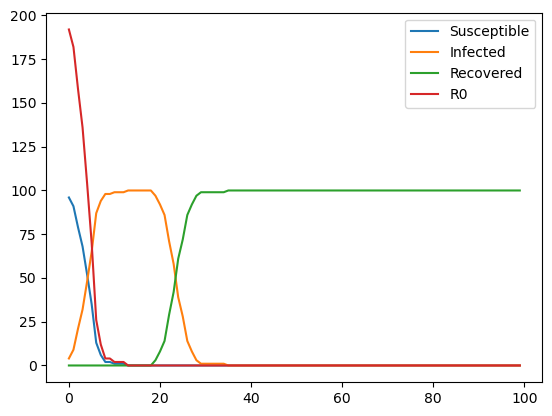

In [69]:
data.plot()
plt.show()

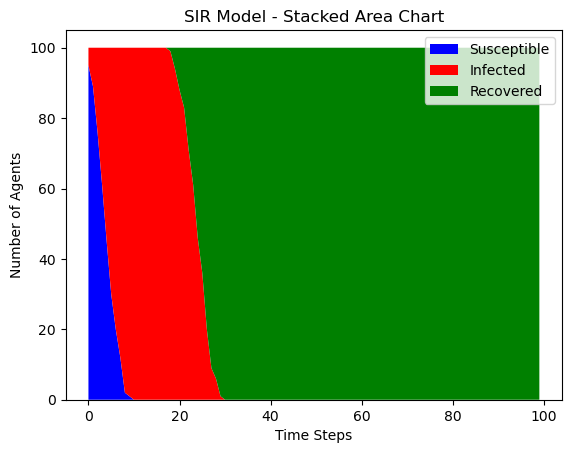

In [72]:
# Generar gráfica de áreas apiladas
plt.stackplot(data.index, 
              data['Susceptible'], 
              data['Infected'], 
              data['Recovered'],
              labels=['Susceptible', 'Infected', 'Recovered'],
              colors=['blue', 'red', 'green'])
plt.title("SIR Model - Stacked Area Chart")
plt.xlabel("Time Steps")
plt.ylabel("Number of Agents")
plt.legend(loc='upper right')
plt.show()

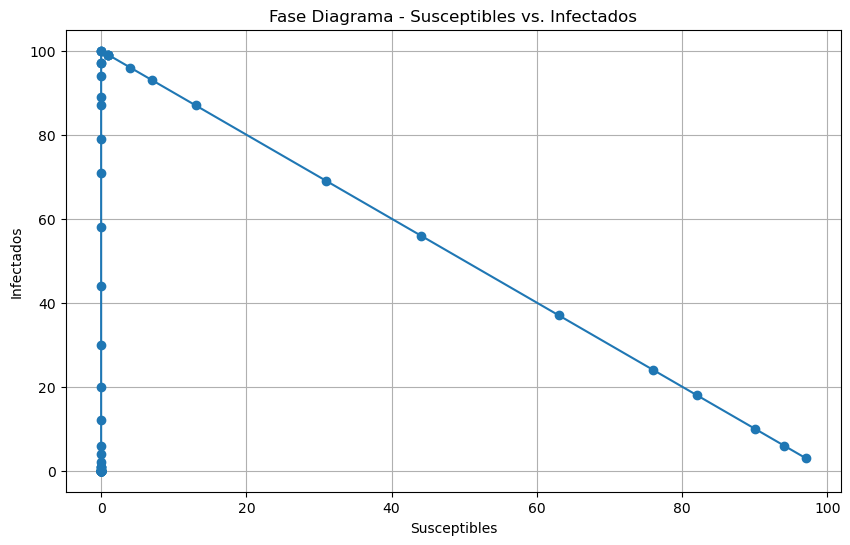

In [46]:
# Diagrama de Fase

plt.figure(figsize=(10, 6))
plt.plot(data['Susceptible'], data['Infected'], '-o')
plt.title("Fase Diagrama - Susceptibles vs. Infectados")
plt.xlabel("Susceptibles")
plt.ylabel("Infectados")
plt.grid(True)
plt.show()

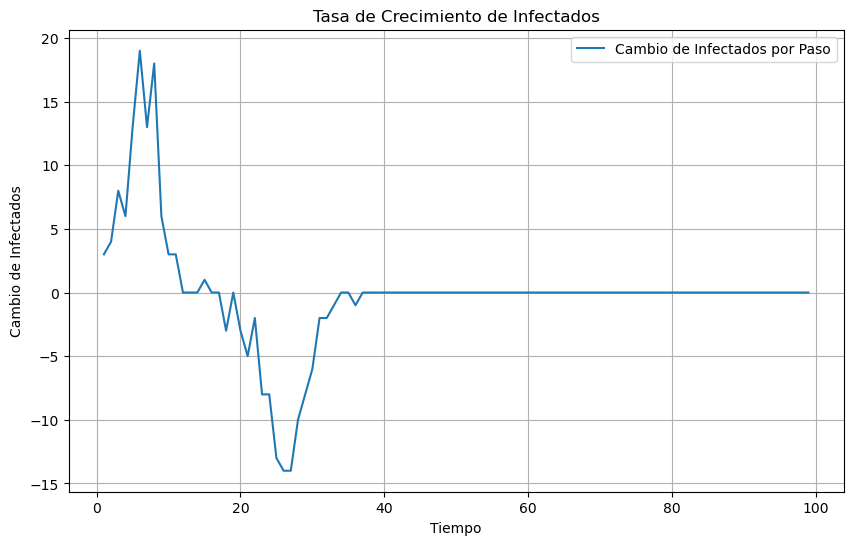

In [47]:
# Calcular la diferencia de infectados entre cada paso
data['Infectados_cambio'] = data['Infected'].diff()

plt.figure(figsize=(10, 6))
plt.plot(data['Infectados_cambio'], label='Cambio de Infectados por Paso')
plt.title("Tasa de Crecimiento de Infectados")
plt.xlabel("Tiempo")
plt.ylabel("Cambio de Infectados")
plt.legend()
plt.grid(True)
plt.show()

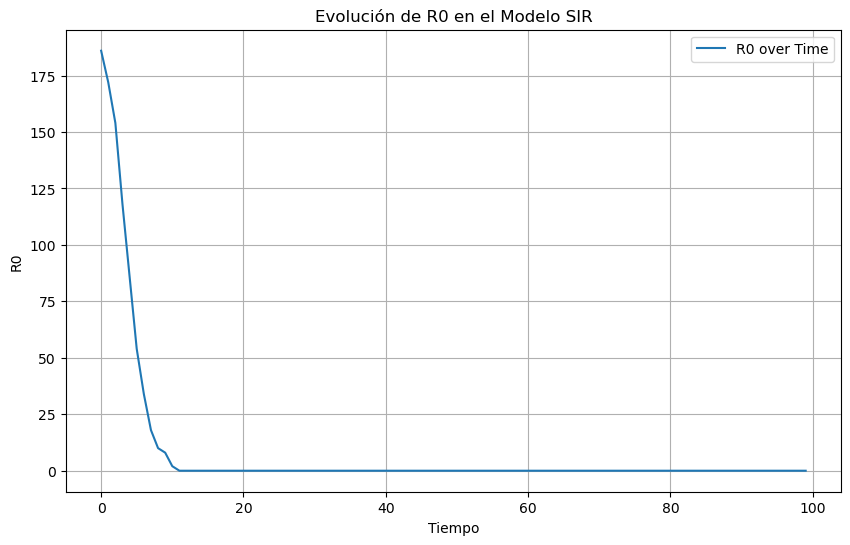

In [50]:
# Suponiendo que 'R0' es recolectado por el DataCollector
data = model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(10, 6))
plt.plot(data['R0'], label='R0 over Time')
plt.title("Evolución de R0 en el Modelo SIR")
plt.xlabel("Tiempo")
plt.ylabel("R0")
plt.legend()
plt.grid(True)
plt.show()

In [45]:
import mesa
from mesa.batchrunner import batch_run
import pandas as pd


# Definición de parámetros
parameters = {
    "N": range(50, 100),
    "width": 10,
    "height": 10,
    "infection_rate": 0.1,
    "recovery_time": 30
}

# Ejecución del batch run
results = batch_run(
    SIRModel,
    parameters,
    number_processes=1,  # Puedes ajustar el número de procesos según sea necesario
    iterations=5,  # Número de veces que se ejecuta el modelo para cada conjunto de parámetros
    max_steps=50,
    display_progress=True  # Muestra el progreso de la ejecución
)


data = pd.DataFrame(results)

  0%|          | 0/250 [00:00<?, ?it/s]

In [43]:
data.head()

RunId  iteration  Step   N  width  height  infection_rate  recovery_time  \
0      0          0    50  50     10      10             0.1             20   
1      1          0    50  51     10      10             0.1             20   
2      2          0    50  52     10      10             0.1             20   
3      3          0    50  53     10      10             0.1             20   
4      4          0    50  54     10      10             0.1             20   

   Susceptible  Infected  Recovered     R0  
0            0         0         50    0.0  
1            0         0         51    0.0  
2            0         0         52    0.0  
3            0         0         53    0.0  
4           54         0          0  108.0

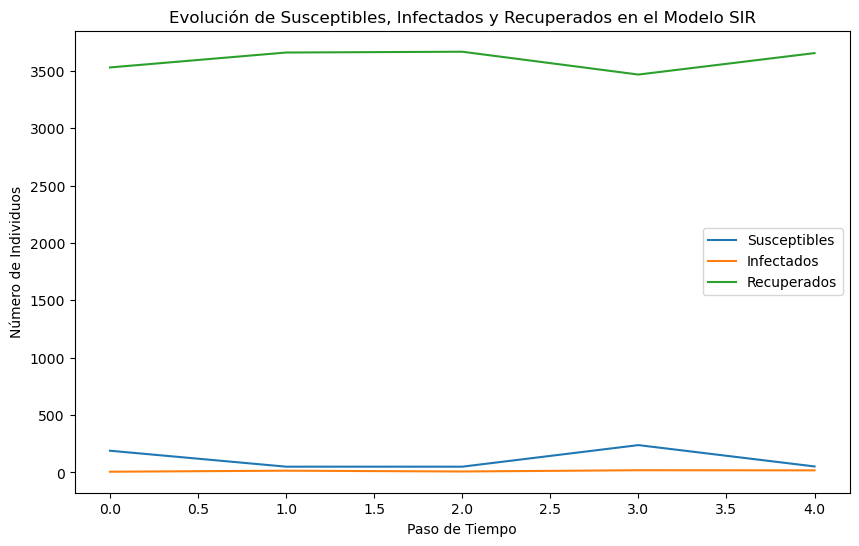

In [46]:
grouped_data = data.groupby('iteration').sum()

# Creando el gráfico
plt.figure(figsize=(10, 6))
plt.plot(grouped_data['Susceptible'], label='Susceptibles')
plt.plot(grouped_data['Infected'], label='Infectados')
plt.plot(grouped_data['Recovered'], label='Recuperados')

plt.xlabel('Paso de Tiempo')
plt.ylabel('Número de Individuos')
plt.title('Evolución de Susceptibles, Infectados y Recuperados en el Modelo SIR')
plt.legend()
plt.show()

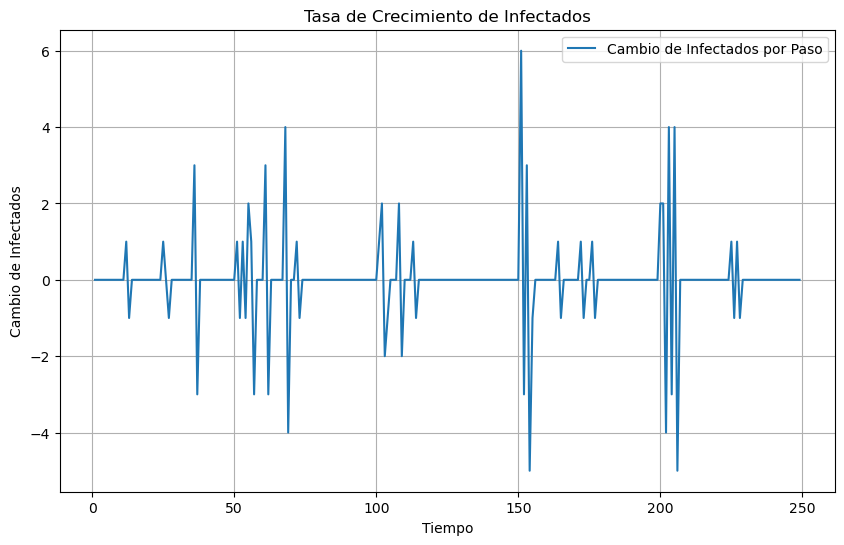

In [47]:


data['Infectados_cambio'] = data['Infected'].diff()

plt.figure(figsize=(10, 6))
plt.plot(data['Infectados_cambio'], label='Cambio de Infectados por Paso')
plt.title("Tasa de Crecimiento de Infectados")
plt.xlabel("Tiempo")
plt.ylabel("Cambio de Infectados")
plt.legend()
plt.grid(True)
plt.show()

In [66]:
import mesa
from mesa.batchrunner import batch_run
import pandas as pd


# Definición de parámetros
parameters = {
    "N": 500,
    "width": 10,
    "height": 10,
    "infection_rate": [0.01, 0.1, 0.25, 0.4],
    "recovery_time": 20
}

# Ejecución del batch run
results = batch_run(
    SIRModel,
    parameters,
    number_processes=1,  # Puedes ajustar el número de procesos según sea necesario
    iterations=3,  # Número de veces que se ejecuta el modelo para cada conjunto de parámetros
    max_steps=20,
    display_progress=True  # Muestra el progreso de la ejecución
)


data = pd.DataFrame(results)

  0%|          | 0/12 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

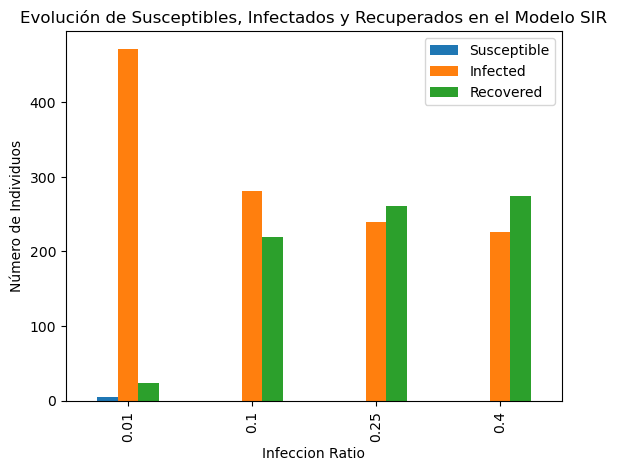

In [67]:
grouped_data = data.groupby('infection_rate')[['Susceptible', 'Infected', 'Recovered']].mean()

# Creando el gráfico
plt.figure(figsize=(10, 6))
grouped_data.plot(kind='bar')


plt.xlabel('Infeccion Ratio')
plt.ylabel('Número de Individuos')
plt.title('Evolución de Susceptibles, Infectados y Recuperados en el Modelo SIR')
plt.legend()
plt.show()